In [1]:
from __future__ import unicode_literals
import unicodedata
import string
import io
import glob
import os
import random
import math
import time

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
## Link to datasets -- 

In [2]:
all_letters = string.ascii_letters + ".,;'"
n_letters= len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

def findFiles(path):
    return glob.glob(path)

def readLines(filename):
    #lines = io.open(filename, encoding = 'utf-8').read().strip().split('\n')
    with open(filename, encoding = 'utf-8') as f:
        lines = f.read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [3]:
print(unicodeToAscii('Ślusàrski'))
print(findFiles('./data/names/*.txt'))

Slusarski
['./data/names/Arabic.txt', './data/names/English.txt', './data/names/Italian.txt', './data/names/Portuguese.txt', './data/names/German.txt', './data/names/Vietnamese.txt', './data/names/Dutch.txt', './data/names/Scottish.txt', './data/names/Spanish.txt', './data/names/Japanese.txt', './data/names/Czech.txt', './data/names/Irish.txt', './data/names/Chinese.txt', './data/names/French.txt', './data/names/Greek.txt', './data/names/Polish.txt', './data/names/Russian.txt', './data/names/Korean.txt']


In [4]:
os.path.splitext(os.path.basename('./data/names/Arabic.txt'))[0]

'Arabic'

In [5]:
category_lines = {}
all_categories = []

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [6]:
category_lines['Korean'][:5]

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']

In [7]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [8]:
print(all_letters)
print(letterToIndex('A'))
print(letterToTensor('A'))
print(lineToTensor('Apt'))
print(lineToTensor('Apt').size())

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'
26
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [9]:
# model

class NET(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NET, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
net = NET(n_letters, n_hidden, n_categories)

In [10]:
#modelling example

input = lineToTensor('Jones')
print(input.size())
hidden = torch.zeros(1, n_hidden)
output, next_hidden = net(input[0], hidden)
print(output)
print(output.topk(1))

torch.Size([5, 1, 56])
tensor([[-2.8600, -2.8223, -2.9674, -2.8477, -2.9768, -3.0065, -2.8982, -2.9482,
         -2.7647, -2.9053, -2.9234, -2.8563, -2.7916, -2.9062, -2.8842, -2.8819,
         -2.9142, -2.9053]], grad_fn=<LogSoftmaxBackward>)
torch.return_types.topk(
values=tensor([[-2.7647]], grad_fn=<TopkBackward>),
indices=tensor([[8]]))


In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
    
print(categoryFromOutput(output))

('Spanish', 8)


In [12]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTraining():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTraining()
    print(f'category = {category} / line = {line}')

category = Russian / line = Glazunov
category = French / line = Herriot
category = Arabic / line = Khoury
category = German / line = Rier
category = Dutch / line = Kranz
category = Irish / line = Ruaidh
category = Scottish / line = Mckay
category = Portuguese / line = Fernandes
category = Czech / line = Maly
category = Russian / line = Tur


In [13]:
criterion = nn.NLLLoss()
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = net.initHidden()
    net.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameter gradient and lr
    for p in net.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
        
    return output, loss.item()

def timeSince(since):
    now = time.time()
    secs = now - since
    mins = math.floor(secs/60)
    #secs -= mins * 60
    secs_left = secs - (mins * 60)
    return '%dm %ds'% (mins, secs_left)

In [14]:
epochs = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []
start = time.time()

for epoch in range(epochs+1):
    category, line, category_tensor, line_tensor = randomTraining()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if epoch % print_every == 0:
        country, country_i = categoryFromOutput(output)
        correct = '✓' if country == category else '✗ (%s)' % category
        print(f'Epoch {epoch} {epoch/ epochs * 100} ({timeSince(start)})\
         | Loss {loss:.4f} | Line {line} / {country} {correct}')
        
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Epoch 0 0.0 (0m 0s)         | Loss 2.8611 | Line Morcos / Spanish ✗ (Arabic)
Epoch 5000 5.0 (0m 39s)         | Loss 2.7338 | Line Sylvester / Dutch ✗ (English)
Epoch 10000 10.0 (1m 4s)         | Loss 2.7475 | Line Dufour / Arabic ✗ (French)
Epoch 15000 15.0 (1m 26s)         | Loss 3.0825 | Line Hunter / German ✗ (Scottish)
Epoch 20000 20.0 (1m 49s)         | Loss 2.1722 | Line Abadi / Italian ✗ (Arabic)
Epoch 25000 25.0 (2m 12s)         | Loss 1.8134 | Line Duan / Vietnamese ✗ (Chinese)
Epoch 30000 30.0 (2m 35s)         | Loss 0.7955 | Line Dubicki / Polish ✓
Epoch 35000 35.0 (3m 0s)         | Loss 1.6145 | Line Almeida / Czech ✗ (Portuguese)
Epoch 40000 40.0 (3m 22s)         | Loss 2.3070 | Line Armistead / Scottish ✗ (French)
Epoch 45000 45.0 (3m 45s)         | Loss 0.0306 | Line Kikkawa / Japanese ✓
Epoch 50000 50.0 (4m 8s)         | Loss 0.6059 | Line Barros / Portuguese ✓
Epoch 55000 55.00000000000001 (4m 38s)         | Loss 1.0983 | Line Anikin / Russian ✓
Epoch 60000 60.0 (5m 4s

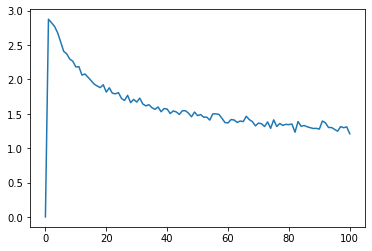

In [15]:
import matplotlib.pyplot as plt

plt.plot(all_losses)

In [19]:
#predict

def predict(input_line, n_predictions =3):
    print('\n> ', input_line)
    with torch.no_grad():
        hidden = net.initHidden()
        line_tensor = lineToTensor(input_line)
        
        for i in range(line_tensor.size()[0]):
            output, hidden = net(line_tensor[i], hidden)
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            #predictions.append([value, all_categories[category_index]])

In [20]:
print(predict('Satoshi'))
print(predict('Jones'))
print(predict('Dovesky'))
print(predict('Jackson'))


>  Satoshi
(-0.94) Japanese
(-1.12) Italian
(-1.90) Arabic
None

>  Jones
(-1.42) Dutch
(-1.57) English
(-1.99) Spanish
None

>  Dovesky
(-0.38) Russian
(-1.49) Czech
(-2.68) English
None

>  Jackson
(-0.49) Scottish
(-1.30) English
(-2.92) Russian
None
